In [2]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

> First, we need to read in the DF we cleaned up in data_exploration.ipynb.

In [31]:
# We also need to convert the data types again it seems.
df=pd.read_csv('resources/clean_with_prices.csv')
df=df.set_index('VIN')
call_pricing_df=df.loc[df['price']=='Call for Pricing'].reset_index().drop(['price','Stock #','VIN','Color'],axis=1)
prices_df=df.drop(df.loc[df['price']=='Call for Pricing'].index)
converted_df=prices_df.convert_dtypes()
converted_df['price']=round(converted_df['price'].astype(float),2)
converted_df['Color']=[x.lower() for x in converted_df['Color']]
call_pricing_df

,Cab Type,Drivetrain,Rear Wheels,Fuel Type,Transmission,Vehicle Trim
0,Crew,4x2,SRW,Gasoline,6-Speed Automatic Electronic with Overdrive,WT
1,Crew,4x4,SRW,Gasoline,8-Speed Automatic 8HP75 Transmission,LARAMIE CREW CAB 4X4 5'7 BOX
2,Crew,4x4,SRW,Gasoline,8-Speed Automatic 8HP75 Transmission,BIG HORN CREW CAB 4X4 5'7 BOX
3,Mega,4x4,SRW,Diesel,6-Speed Automatic 68RFE Transmission,LARAMIE MEGA CAB 4X4 6'4 BOX
4,Mega,4x4,SRW,Diesel,6-Speed Automatic 68RFE Transmission,LARAMIE MEGA CAB 4X4 6'4 BOX
...,...,...,...,...,...,...
1586,Super,4x4,SRW,Gasoline,Automatic,XL
1587,Regular,4x4,SRW,Gasoline,Automatic,XL
1588,Crew,4x4,SRW,Gasoline,8-Speed Automatic,SLE
1589,Crew,4x4,SRW,Gasoline,8-Speed Automatic,SLE


> Next, we need to preprocess the data by encoding all of our categorical features and splitting up the data into training and testing. We will omit color as a feature for now since we can assume this doesn't affect price meaningfuly. Shown below is the encoded feature set.

In [39]:
y=converted_df['price']
encoder=LabelEncoder()
X=converted_df.iloc[:,2:9].reset_index().drop(['VIN','Color'],axis=1)
X=X.to_numpy(copy=True)
call_prices=call_pricing_df.to_numpy(copy=True)
for i in range(len(X)):
    X[i]=encoder.fit_transform(X[i])
# print(X) 
for i in range(len(call_prices)):
    call_prices[i]=encoder.fit_transform(call_prices[i])
# print(call_prices)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_scaler = MinMaxScaler().fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [40]:
def plot_complexity_curve(k_list, knn_model, x_train, x_test, y_train, y_test):
    
    train_scores = []
    test_scores = []
    
    # For each k
    for k in k_list:
        # Initialize, fit, predict
        knn = knn_model(k)
        
        knn.fit(x_train, y_train)
        
        train_scores.append(knn.score(x_train, y_train))
        test_scores.append(knn.score(x_test, y_test))

    # Plot
    fig, ax = plt.subplots()
    
    ax.plot(k_list, train_scores, label='Training Accuracy', color='red')
    ax.plot(k_list, test_scores, label='Testing Accuracy', color='black')

    ax.set(title='k-NN with Different Values for $k$',
           xlabel='Number of Neighbors',
           ylabel='Accuracy')
    
    ax.legend()

> k=17 seems like our best bet.

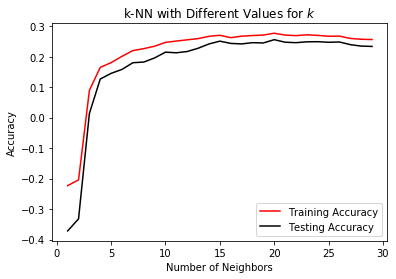

In [41]:
k=np.arange(1,30)
plot_complexity_curve(k, KNeighborsRegressor, X_train_scaled, X_test_scaled, y_train, y_test)

In [42]:
knnR=KNeighborsRegressor(n_neighbors=17)
knnR.fit(X_train_scaled, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=17, p=2,
                    weights='uniform')

> Now we use our model to generate a DF with the new predicted value for each of the 'Call for Pricing' listings.

In [43]:
predicted_df=df.copy().loc[df['price']=='Call for Pricing'].rename(columns={'price':'predicted price'})
predicted_df['predicted price']=knnR.predict(call_prices).round(2)
predicted_df.to_csv('resources/predicted_price.csv')
predicted_df

,predicted price,Stock #,Cab Type,Drivetrain,Rear Wheels,Fuel Type,Transmission,Color,Vehicle Trim
VIN,,,,,,,,,
3GCPWAEHXMG239509,47782.82,210846,Crew,4x2,SRW,Gasoline,6-Speed Automatic Electronic with Overdrive,White,WT
1C6SRFJTXMN698885,48834.94,C18375,Crew,4x4,SRW,Gasoline,8-Speed Automatic 8HP75 Transmission,Maximum Steel,LARAMIE CREW CAB 4X4 5'7 BOX
1C6SRFFT0MN697446,50229.06,C18354,Crew,4x4,SRW,Gasoline,8-Speed Automatic 8HP75 Transmission,Tank,BIG HORN CREW CAB 4X4 5'7 BOX
3C6UR5NL4MG582958,68726.29,C18360,Mega,4x4,SRW,Diesel,6-Speed Automatic 68RFE Transmission,Diamond Black Crystal Pearlcoat,LARAMIE MEGA CAB 4X4 6'4 BOX
3C6UR5NL6MG582959,68726.29,C18376,Mega,4x4,SRW,Diesel,6-Speed Automatic 68RFE Transmission,Granite Crystal,LARAMIE MEGA CAB 4X4 6'4 BOX
...,...,...,...,...,...,...,...,...,...
1FTFX1E59MKD90753,46086.88,MX1E0002*O,Super,4x4,SRW,Gasoline,Automatic,Oxford White,XL
1FTMF1EP0MKD90748,33828.59,MF1E0003*O,Regular,4x4,SRW,Gasoline,Automatic,Oxford White,XL
1GTU9BED5LZ229515,48834.94,CH900,Crew,4x4,SRW,Gasoline,8-Speed Automatic,Summit White,SLE


In [45]:
predicted_df.describe()

,predicted price
count,1591.000000
mean,48972.305713
std,6901.533467
min,33828.590000
25%,46086.880000
50%,48834.940000
75%,50229.060000
max,70115.940000
